# Data Exploration

In [1]:
import pandas as pd

# URL-адреса файлу з даними
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'

# Назви стовпців
column_names = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'
]

# Завантаження даних у датафрейм
df = pd.read_csv(url, names=column_names, sep=r'\s*,\s*', engine='python', na_values='?')

# Виведення перших 10 рядків
df.head(10)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  31978 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [7]:
df.size

488415

In [8]:
df.isna().sum()


age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income               0
dtype: int64

In [9]:
# відсутні дані про рідну країну є видом MCAR, тому їх ми просто видалимо
df = df.dropna(subset=['native-country'])

In [10]:
# Оскільки робітничий клас та професію,
#  люди могли відмовитись вказувати з особистих причин, 
# тому тут використаємо регресійну імпутацію

from sklearn.ensemble import HistGradientBoostingClassifier

# Колонки для імпутації
columns_to_impute = ['workclass', 'occupation']

# Визначаємо категоріальні колонки (крім цільових)
categorical_cols = df.select_dtypes(include=['object']).columns.difference(columns_to_impute)

# Зберігаємо унікальні значення цільових колонок (для розкодування)
original_categories = {col: df[col].dropna().unique() for col in columns_to_impute}

# Закодовуємо тільки вхідні змінні
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

for column in columns_to_impute:
    if df[column].isnull().sum() > 0:
        # Вхідні змінні (тільки числові)
        X_train = df_encoded[df[column].notnull()].drop(columns_to_impute, axis=1)
        y_train = df[df[column].notnull()][column]
        X_test = df_encoded[df[column].isnull()].drop(columns_to_impute, axis=1)

        # Навчання моделі
        model = HistGradientBoostingClassifier()
        model.fit(X_train, y_train)
        predicted_values = model.predict(X_test)

        # Заповнюємо пропущені значення
        df.loc[df[column].isnull(), column] = predicted_values

        # **Розкодування назад (приводимо до початкових категорій)**
        df[column] = df[column].astype(pd.CategoricalDtype(categories=original_categories[column]))


c:\Users\Наталія\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Наталія\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\Наталія\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Наталія\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", l

- Зробіть описову статистику для кількісних ознак.

In [11]:
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,31978.000000,3.197800e+04,31978.000000,31978.000000,31978.000000,31978.000000
mean,38.579023,1.897141e+05,10.071236,1064.360623,86.739352,40.417850
std,13.662085,1.057255e+05,2.560667,7298.596271,401.594301,12.345285
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.176202e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783120e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.373790e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [12]:
print(df['workclass'].value_counts())
print('-------------------------------------------------------')
print(df['education'].value_counts())
print('-------------------------------------------------------')
print(df['marital-status'].value_counts())
print('-------------------------------------------------------')
print(df['occupation'].value_counts())
print('-------------------------------------------------------')
print(df['relationship'].value_counts())
print('-------------------------------------------------------')
print(df['race'].value_counts())
print('-------------------------------------------------------')
print(df['sex'].value_counts())
print('-------------------------------------------------------')
print(df['native-country'].value_counts())
print('-------------------------------------------------------')

print(df['income'].value_counts())


workclass
Private             24026
Self-emp-not-inc     2541
Local-gov            2070
State-gov            1283
Self-emp-inc         1076
Federal-gov           946
Without-pay            24
Never-worked           12
Name: count, dtype: int64
-------------------------------------------------------
education
HS-grad         10368
Some-college     7187
Bachelors        5210
Masters          1674
Assoc-voc        1366
11th             1167
Assoc-acdm       1055
10th              921
7th-8th           627
Prof-school       559
9th               506
12th              417
Doctorate         390
5th-6th           318
1st-4th           163
Preschool          50
Name: count, dtype: int64
-------------------------------------------------------
marital-status
Married-civ-spouse       14692
Never-married            10488
Divorced                  4394
Separated                 1005
Widowed                    979
Married-spouse-absent      397
Married-AF-spouse           23
Name: count, dtype: int6

### Factors Affecting Income  
Income can be influenced by the following factors:  
- **Education**  
- **Working hours**  
- **Position**  
- **Capital gains and losses**

It was noted that there are **missing values** in the data.  

There will be no correlation with the following factors:  
- **Gender**  
- **Race**  
- **Country of origin**  
- **Industry**  
- **Marital status**

# Visualization

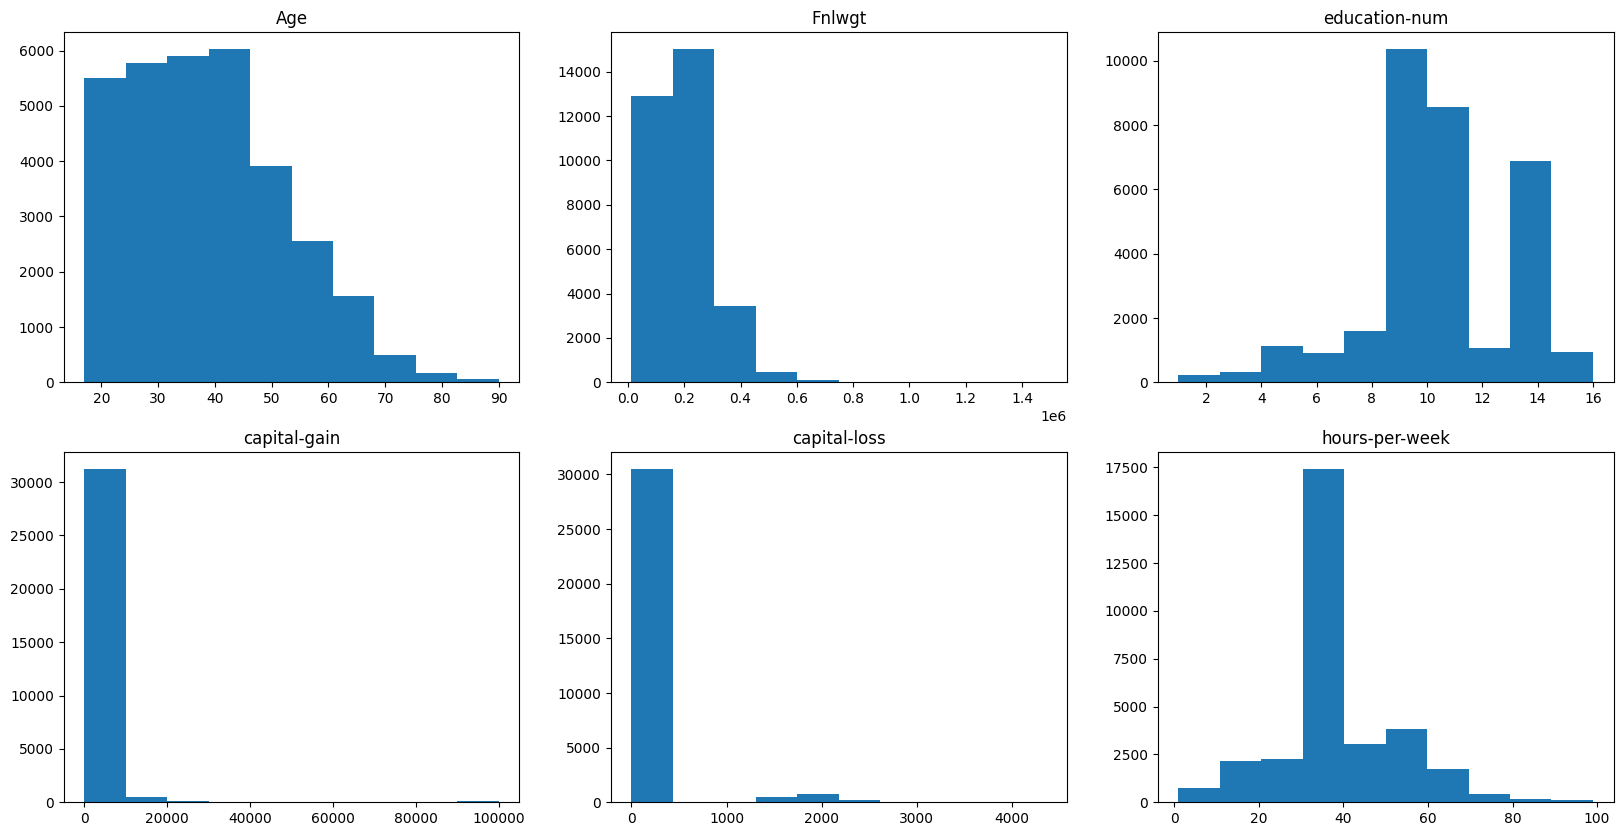

In [13]:
import matplotlib.pyplot as plt

fig, ax  = plt.subplots(2,3, figsize = (20, 10))

ax[0][0].hist(df['age'])
ax[0][0].set_title('Age')

ax[0][1].hist(df['fnlwgt'])
ax[0][1].set_title('Fnlwgt')

ax[0][2].hist(df['education-num'])
ax[0][2].set_title('education-num')

ax[1][0].hist(df['capital-gain'])
ax[1][0].set_title('capital-gain')

ax[1][1].hist(df['capital-loss'])
ax[1][1].set_title('capital-loss')

ax[1][2].hist(df['hours-per-week'])
ax[1][2].set_title('hours-per-week')

plt.show()

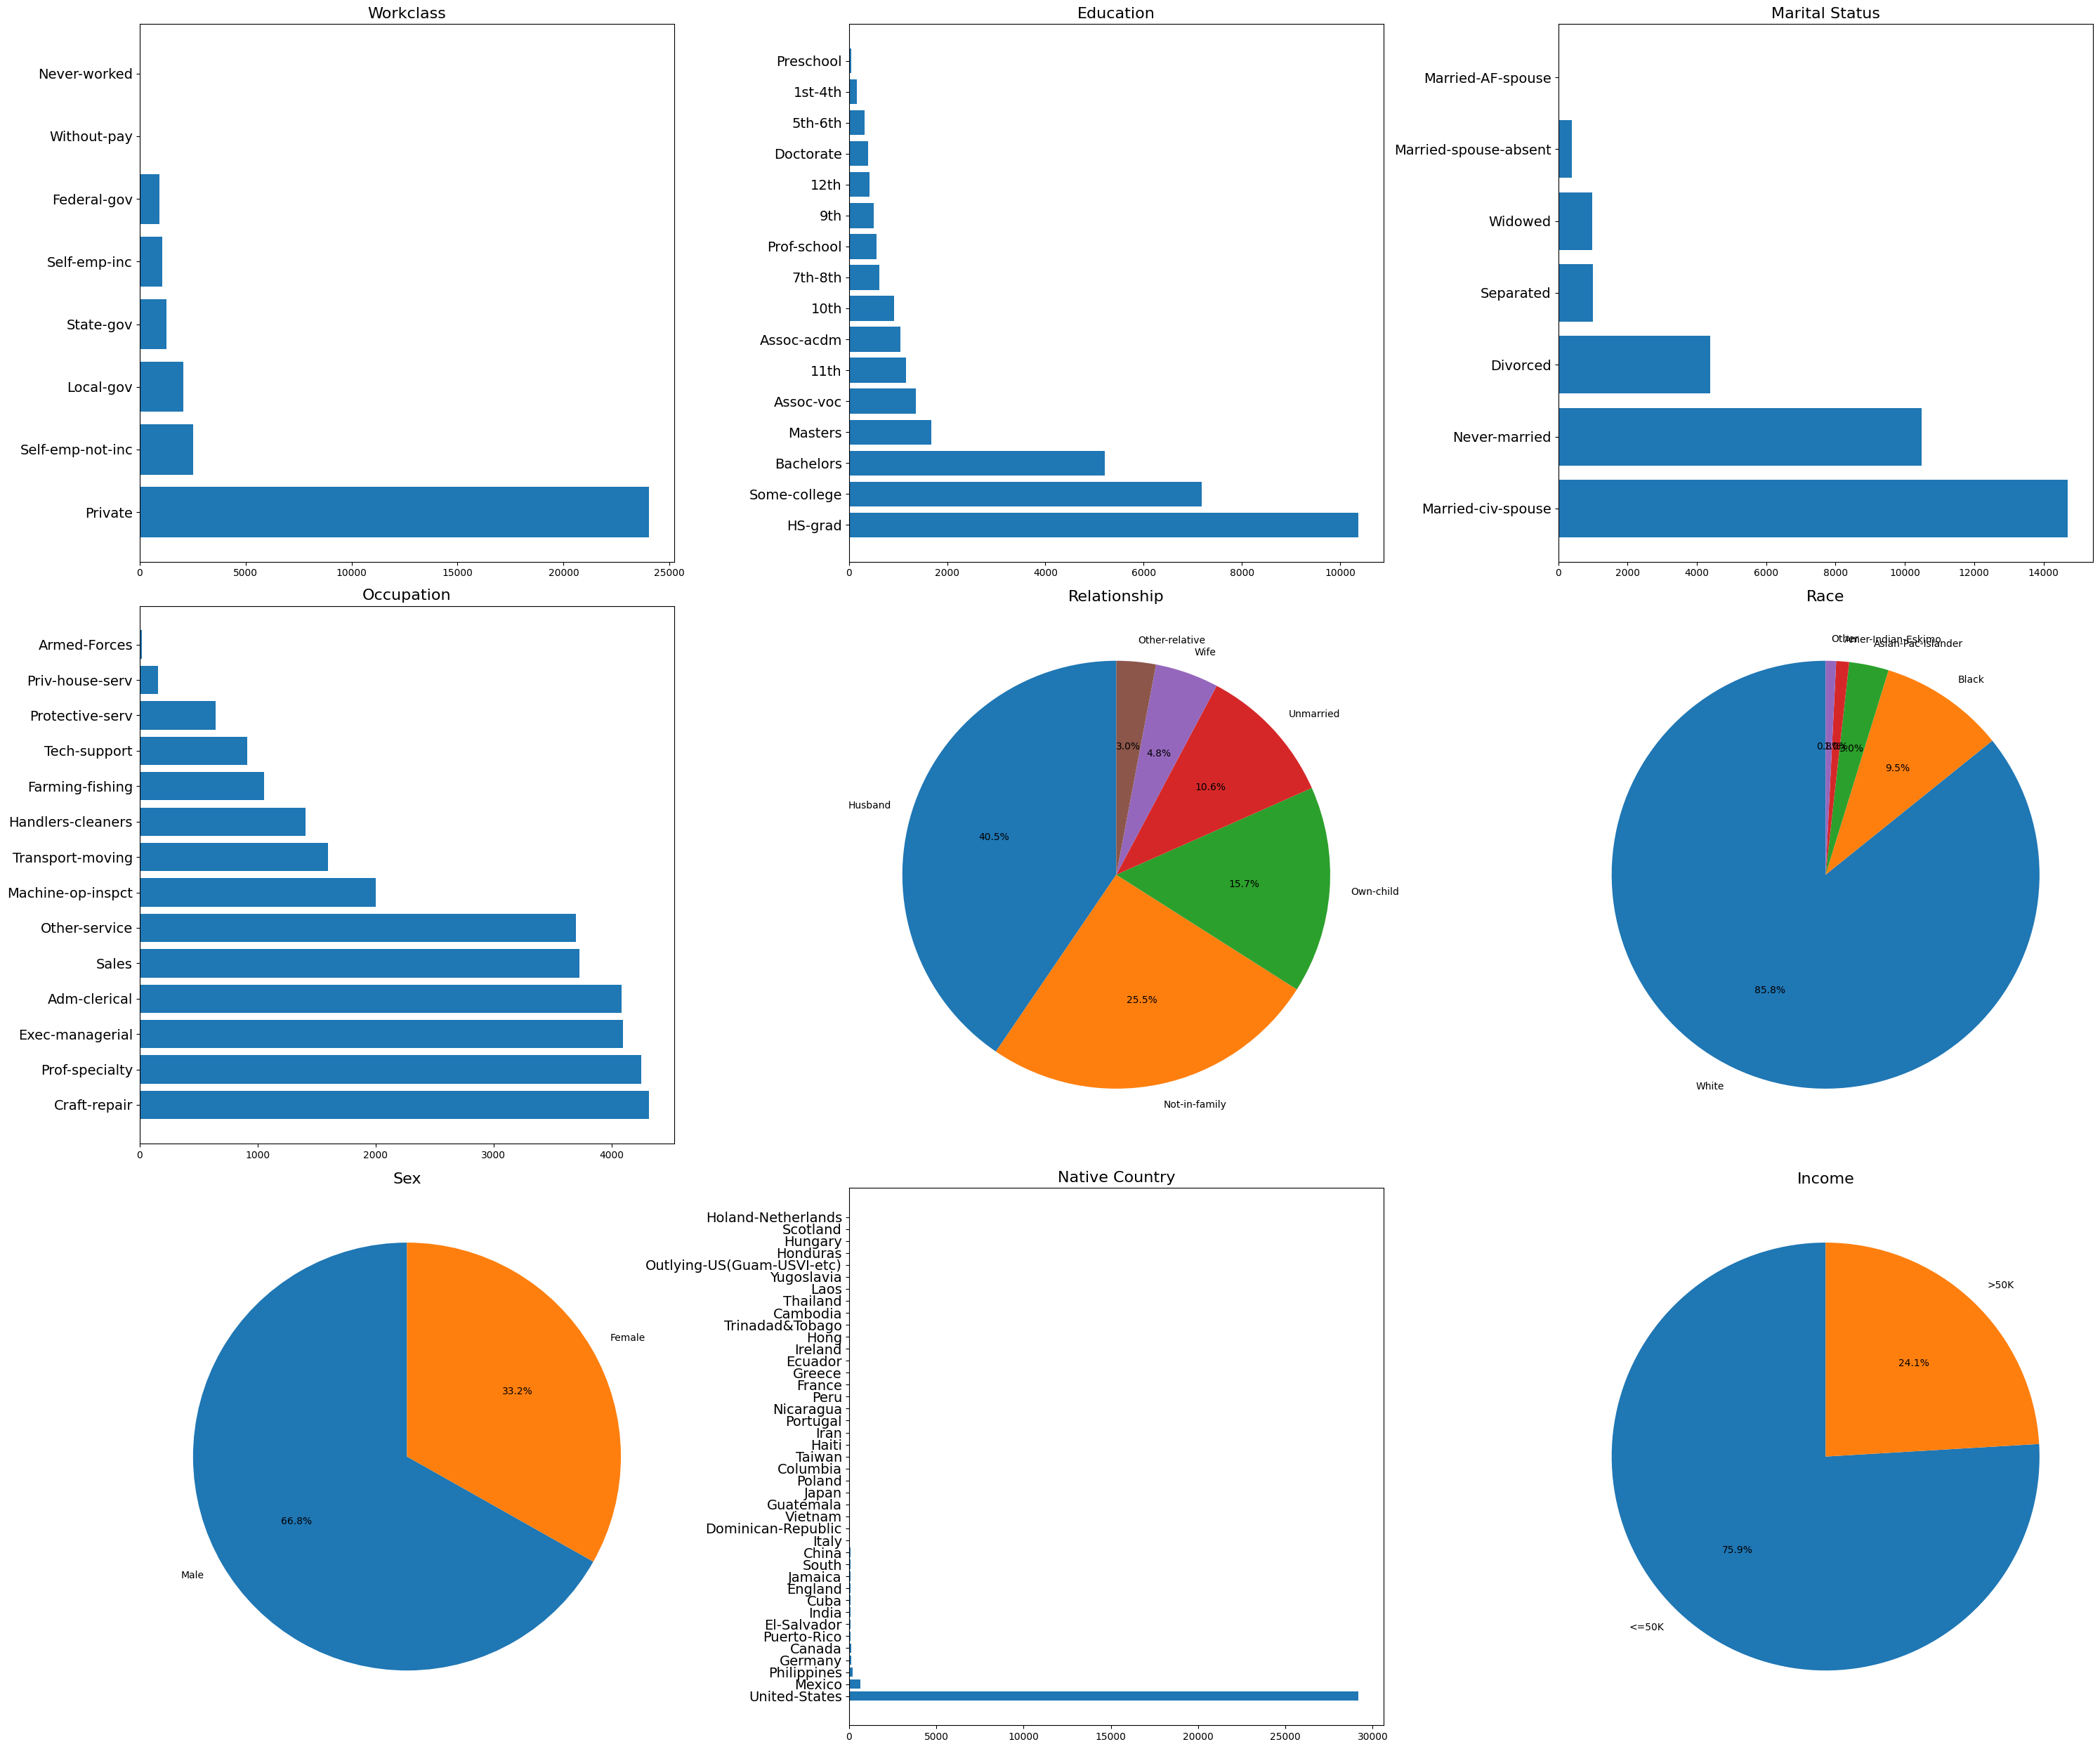

In [14]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 3, figsize=(30, 25))
axes = axes.flatten()

cat_features = {
    'Workclass': df['workclass'].value_counts(),
    'Education': df['education'].value_counts(),
    'Marital Status': df['marital-status'].value_counts(),
    'Occupation': df['occupation'].value_counts(),
    'Relationship': df['relationship'].value_counts(),
    'Race': df['race'].value_counts(),
    'Sex': df['sex'].value_counts(),
    'Native Country': df['native-country'].value_counts(),
    'Income': df['income'].value_counts()
}

for i, (title, data) in enumerate(cat_features.items()):
    ax = axes[i]

    if len(data) <= 6:
        ax.pie(data.values, labels=data.index, autopct='%1.1f%%', startangle=90)
    else:
        ax.barh(data.index, data.values)
        ax.set_yticks(range(len(data)))
        ax.set_yticklabels(data.index, fontsize=14)

    ax.set_title(title, fontsize=16)

plt.tight_layout()
plt.show()


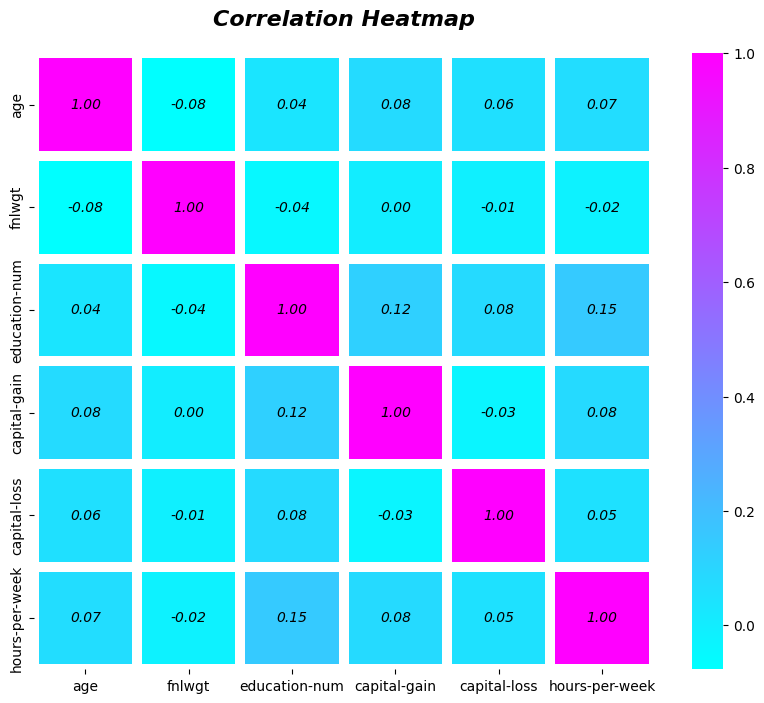

In [15]:
import seaborn as sns
# Вибираємо лише кількісні (числові) колонки
numeric_cols = df.select_dtypes(include=['number'])

correlation_matrix = df.select_dtypes(include=['number']).corr()
# Побудова теплової карти
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="cool", linewidths=6, annot_kws={"size": 10, 'color': 'black', 'style': 'italic'})
plt.title("Correlation Heatmap", fontsize=16, fontweight='bold', pad=20, style = 'italic')
plt.show()

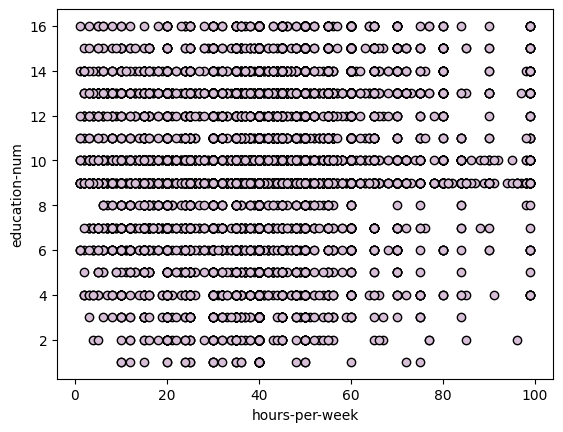

In [16]:
plt.scatter(x=df['hours-per-week'], y=df['education-num'], color = 'thistle', edgecolors='black')
plt.xlabel('hours-per-week')
plt.ylabel('education-num')
plt.show()

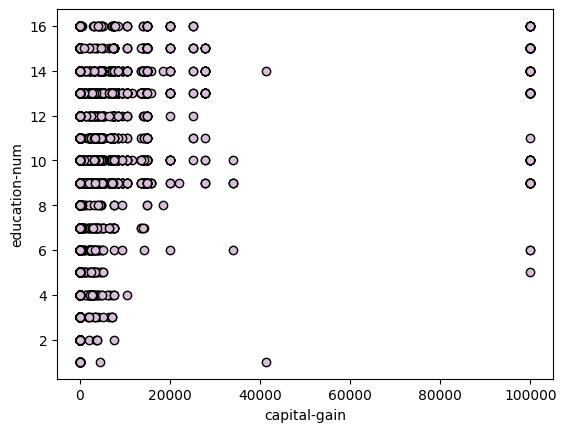

In [17]:
plt.scatter(x=df['capital-gain'], y=df['education-num'], color = 'thistle', edgecolors='black')
plt.xlabel('capital-gain')
plt.ylabel('education-num')
plt.show()

<BarContainer object of 65 artists>

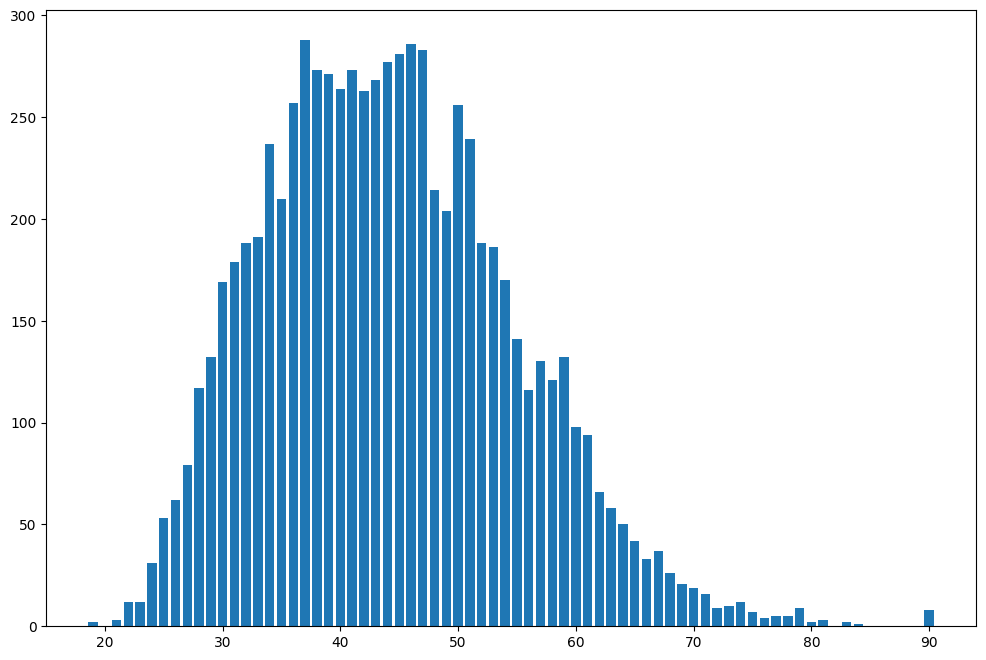

In [18]:
inc_age = df[df['income' ] == '>50K'].groupby('age')['income'].count()
fig, ax = plt.subplots(figsize=(12, 8))
plt.bar(inc_age.index, inc_age.values)

<BarContainer object of 15 artists>

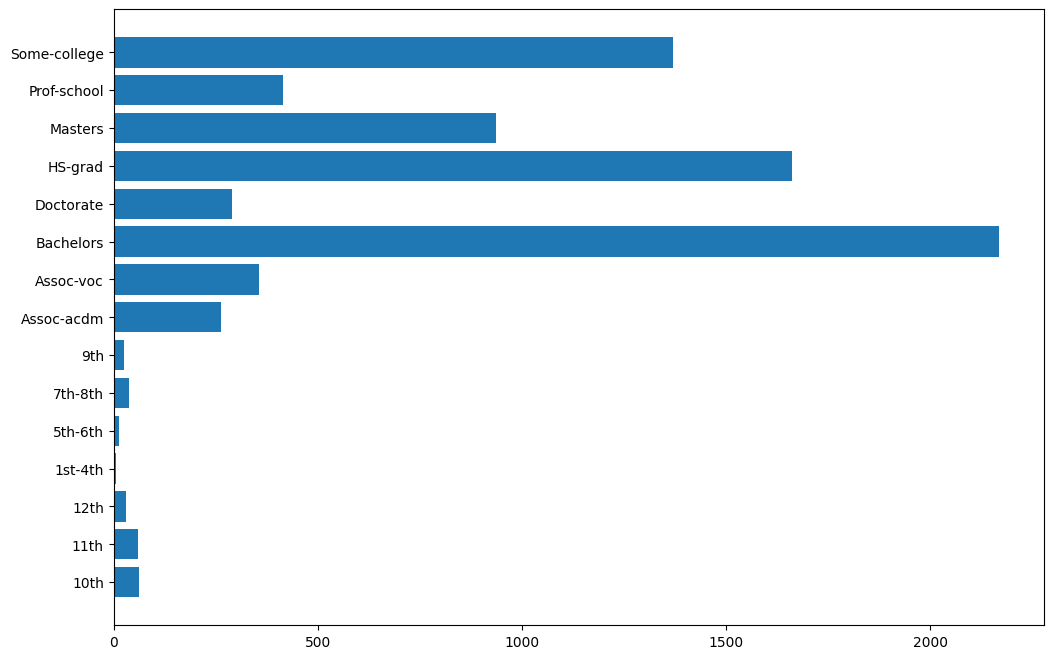

In [19]:
inc_ed = df[df['income' ] == '>50K'].groupby('education')['income'].count()
fig, ax = plt.subplots(figsize=(12, 8))
plt.barh(inc_ed.index, inc_ed.values)

<BarContainer object of 16 artists>

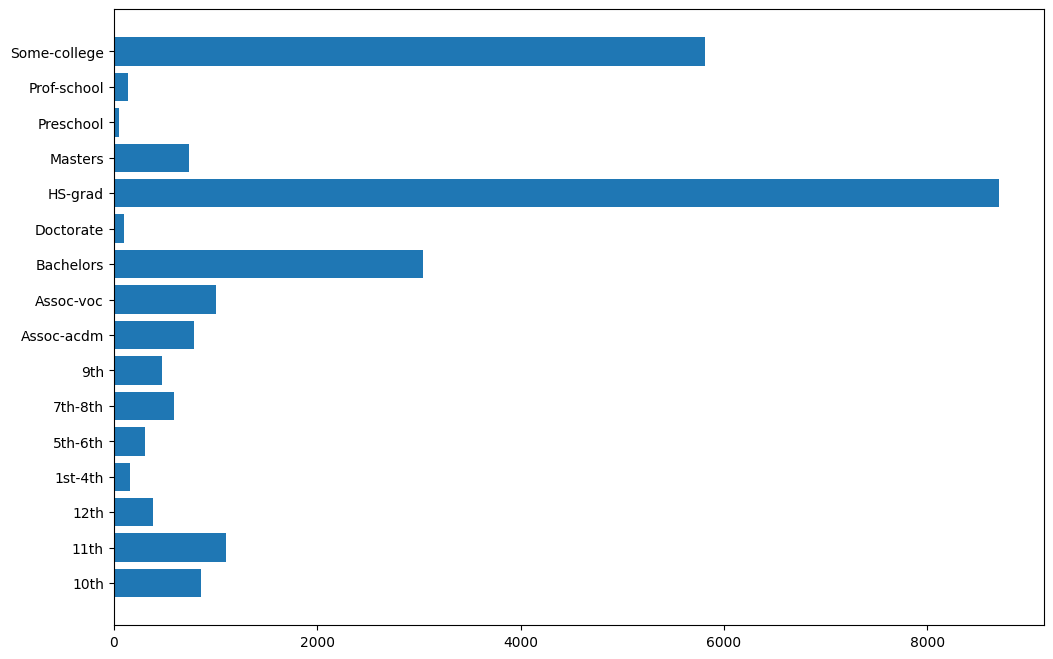

In [20]:
inc_ed = df[df['income' ] == '<=50K'].groupby('education')['income'].count()
fig, ax = plt.subplots(figsize=(12, 8))
plt.barh(inc_ed.index, inc_ed.values)

### Excluded Features and Insights  
We do not need to consider the following features:  
- **Gender**  
- **Race**  
- **Country of origin**  
- **Marital status**  

Additionally, the graphs revealed that the majority of **capital-gain** and **capital-loss** values are 0.  

The highest income is observed among individuals with a **Bachelor's degree** and those aged **36-37** and **46-47** years.

# Data Preparation

In [21]:
df = df.drop(['race', 'sex', 'native-country', 'marital-status', 'relationship'], axis=1)


In [23]:
threshold = 0.05  
for col in df.select_dtypes(include='object'):
    if col == 'income':  
            continue  
    category_counts = df[col].value_counts()
    min_count = threshold * category_counts.mean()
    valid_categories = category_counts[category_counts > min_count].index
    df = df[df[col].isin(valid_categories)]


In [24]:
df['income'].value_counts()

income
<=50K    24233
>50K      7695
Name: count, dtype: int64

In [25]:
from sklearn.utils import resample


# Розділення даних на класи
class_0 = df[df['income'] == '<=50K']
class_1 = df[df['income'] == '>50K']
# Кількість елементів, що залишиться, дорівнює кількості елементів в першому класі
class_0_downsampled = resample(class_0, replace=False, n_samples=len(class_1), random_state=42)

# Об'єднання двох класів
df = pd.concat([class_0_downsampled, class_1])

df['income'].value_counts()

income
<=50K    7695
>50K     7695
Name: count, dtype: int64

In [26]:
prestige_mapping = {
    '1st-4th': 1,
    '5th-6th': 1,
    '7th-8th': 1,
    '9th': 1,
    '10th': 2,
    '11th': 2,
    '12th': 2,
    'HS-grad': 2,
    'Some-college': 4,
    'Assoc-voc': 4,
    'Assoc-acdm': 4,
    'Bachelors': 5,
    'Masters': 6,
    'Prof-school': 6,
    'Doctorate': 7
}


df['education'] = df['education'].map(prestige_mapping)

df = pd.get_dummies(df, columns=['workclass', 'occupation', 'income'], drop_first=True)

df

,age,fnlwgt,education,education-num,capital-gain,capital-loss,hours-per-week,workclass_Self-emp-not-inc,workclass_Private,workclass_Federal-gov,...,occupation_Sales,occupation_Transport-moving,occupation_Farming-fishing,occupation_Machine-op-inspct,occupation_Tech-support,occupation_Craft-repair,occupation_Protective-serv,occupation_Armed-Forces,occupation_Priv-house-serv,income_>50K
6811,44,192878,2,9,0,0,40,False,True,False,...,False,False,False,False,False,False,False,False,False,False
9362,27,273929,2,9,0,0,40,False,False,False,...,False,False,True,False,False,False,False,False,False,False
30331,62,257277,2,9,0,0,38,False,True,False,...,False,False,False,False,False,False,False,False,False,False
15851,27,68037,4,10,0,0,45,False,True,False,...,False,False,False,False,False,False,False,False,False,False
5322,19,165115,2,9,0,0,40,False,True,False,...,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32539,71,287372,7,16,0,0,10,True,False,False,...,False,False,False,False,False,False,False,False,False,True
32545,39,111499,4,12,0,0,20,False,False,False,...,False,False,False,False,False,False,False,False,False,True
32554,53,321865,6,14,0,0,40,False,True,False,...,False,False,False,False,False,False,False,False,False,True
32557,40,154374,2,9,0,0,40,False,True,False,...,False,False,False,True,False,False,False,False,False,True


In [27]:
from sklearn.preprocessing import MinMaxScaler

numerical_features = df.select_dtypes(include=['number']).columns

scaler_minmax = MinMaxScaler()
df[numerical_features] = scaler_minmax.fit_transform(df[numerical_features])

In [28]:
df.head()

,age,fnlwgt,education,education-num,capital-gain,capital-loss,hours-per-week,workclass_Self-emp-not-inc,workclass_Private,workclass_Federal-gov,...,occupation_Sales,occupation_Transport-moving,occupation_Farming-fishing,occupation_Machine-op-inspct,occupation_Tech-support,occupation_Craft-repair,occupation_Protective-serv,occupation_Armed-Forces,occupation_Priv-house-serv,income_>50K
6811,0.369863,0.146900,0.166667,0.500000,0.0,0.0,0.397959,False,True,False,...,False,False,False,False,False,False,False,False,False,False
9362,0.136986,0.213790,0.166667,0.500000,0.0,0.0,0.397959,False,False,False,...,False,False,True,False,False,False,False,False,False,False
30331,0.616438,0.200048,0.166667,0.500000,0.0,0.0,0.377551,False,True,False,...,False,False,False,False,False,False,False,False,False,False
15851,0.136986,0.043871,0.500000,0.571429,0.0,0.0,0.448980,False,True,False,...,False,False,False,False,False,False,False,False,False,False
5322,0.027397,0.123988,0.166667,0.500000,0.0,0.0,0.397959,False,True,False,...,True,False,False,False,False,False,False,False,False,False


In [30]:
X = df.drop(columns=['income_>50K'])
y = df['income_>50K']

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Choosing the model

In [38]:
import warnings
warnings.filterwarnings("ignore")
result = {
    "Model":[],
    'model_config': [],
    'train_score': [],
    'test_score': [],
    'f1-score': []
}

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

Penalty = ['l1', 'l2',  None]
C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
Solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
Max_iter = [100, 500, 1000, 5000]
Fit_intercept = [True, False]


for c in C:
    for solver in Solver:
        for max_iter in Max_iter:
            for penalty in Penalty:
                for fit_intercept in Fit_intercept:
                    # Skip invalid solver-penalty combinations
                    if solver in ['newton-cg', 'lbfgs', 'sag'] and penalty not in ['l2', 'none']:
                        continue
                    if solver == 'liblinear' and penalty not in ['l1', 'l2']:
                        continue
                    if solver == 'saga' and penalty == 'none':
                        continue
                    
                    logistic_model = LogisticRegression(penalty=penalty, C=c, fit_intercept=fit_intercept, max_iter=max_iter, solver=solver)
                    logistic_model.fit(X_train, y_train)

                    y_pred_log = logistic_model.predict(X_test)
                    
                    result['Model'].append('Logistic Regression')
                    result['model_config'].append(f"penalty={penalty}, c ={c}, max_iter={max_iter}, solver ={solver}, fit_intercept={fit_intercept}")
                    result['train_score'].append(logistic_model.score(X_train,y_train))
                    result['test_score'].append(logistic_model.score(X_test, y_test))
                    result['f1-score'].append(f1_score(y_test, y_pred_log))

In [40]:
max_depth_values = [5, 10, 13, 16, 18, 19, 20, 24, 25]
min_samples_split_values = [6, 3, 8]
min_samples_leaf_values = [4, 5, 7]

from sklearn.tree import DecisionTreeClassifier


for max_depth in max_depth_values:
    for min_samples_split in min_samples_split_values:
        for min_samples_leaf in min_samples_leaf_values:

            # Створення та навчання моделі
            model = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
            model.fit(X_train, y_train)
                                   
            y_predict = model.predict(X_test)
            
            result['Model'].append('Decision Tree')
            result['model_config'].append(f"max_depth={max_depth}, min_samples_split={min_samples_split}, min_samples_leaf={min_samples_leaf}")
            result['train_score'].append(model.score(X_train,y_train))
            result['test_score'].append(model.score(X_test, y_test))
            result['f1-score'].append(f1_score(y_test, y_predict))

In [41]:
from sklearn.naive_bayes import GaussianNB
import numpy as np

var_smoothing_values = np.logspace(-9, -1, 10)  # 10 значень від 1e-9 до 1e-1
priors_list = [None, [0.3, 0.7], [0.5, 0.5], [0.7, 0.3]]  # Припустимо, що два класи


# Grid Search по параметрам
for var_smoothing in var_smoothing_values:
    for priors in  priors_list:
        model = GaussianNB(var_smoothing=var_smoothing, priors=priors)
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
         
        result['Model'].append('Naive Bayes')
        result['model_config'].append(f"var_smoothing={var_smoothing}, priors={priors}")
        result['train_score'].append(model.score(X_train, y_train))
        result['test_score'].append(model.score(X_test, y_test))
        result['f1-score'].append(f1_score(y_test, y_pred))

In [59]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

df_result = pd.DataFrame(result)
df_result = df_result.sort_values(by=['test_score', 'f1-score'], ascending=[False, False])
df_result

,Model,model_config,train_score,test_score,f1-score
338,Logistic Regression,"penalty=l2, c =10, max_iter=100, solver =liblinear, fit_intercept=True",0.763320,0.765432,0.768590
342,Logistic Regression,"penalty=l2, c =10, max_iter=500, solver =liblinear, fit_intercept=True",0.763320,0.765432,0.768590
346,Logistic Regression,"penalty=l2, c =10, max_iter=1000, solver =liblinear, fit_intercept=True",0.763320,0.765432,0.768590
350,Logistic Regression,"penalty=l2, c =10, max_iter=5000, solver =liblinear, fit_intercept=True",0.763320,0.765432,0.768590
354,Logistic Regression,"penalty=l2, c =10, max_iter=500, solver =sag, fit_intercept=True",0.763402,0.765432,0.768590
328,Logistic Regression,"penalty=l2, c =10, max_iter=100, solver =lbfgs, fit_intercept=True",0.763077,0.765107,0.768343
330,Logistic Regression,"penalty=l2, c =10, max_iter=500, solver =lbfgs, fit_intercept=True",0.763077,0.765107,0.768343
332,Logistic Regression,"penalty=l2, c =10, max_iter=1000, solver =lbfgs, fit_intercept=True",0.763077,0.765107,0.768343
334,Logistic Regression,"penalty=l2, c =10, max_iter=5000, solver =lbfgs, fit_intercept=True",0.763077,0.765107,0.768343
320,Logistic Regression,"penalty=l2, c =10, max_iter=100, solver =newton-cg, fit_intercept=True",0.763402,0.765107,0.768195


The best model: penalty=l2, c =10, solver =liblinear, fit_intercept=True for all iterations and params penalty=l2, C=10, max_iter=500, solver=sag

In [55]:
single_observation = np.array([[0.369863, 0.146900, 0.166667, 0.500000, 0.000000, 0.0, 0.397959, 
                                False, True, False, False, False, False, False, False, False, 
                                True, False, False, False, False, False, False, False, False, 
                                False, False]])

logistic_model1 = LogisticRegression(penalty='l2', C=10, fit_intercept=True, max_iter=100, solver='liblinear')
logistic_model1.fit(X_train, y_train)

logistic_model1.predict(single_observation)

array([False])

In [60]:
logistic_model2 = LogisticRegression(penalty='l2', C=10, fit_intercept=True, max_iter=500, solver='sag')
logistic_model2.fit(X_train, y_train)

logistic_model2.predict(single_observation)

array([False])

In [62]:
logistic_model3 = LogisticRegression(penalty='l2', C=10, fit_intercept=True, max_iter=500, solver='lbfgs')
logistic_model3.fit(X_train, y_train)

logistic_model3.predict(single_observation)

array([False])